In [20]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [21]:
# data downloading and reading
"""
XLK ETF top 23 components (Technology, 'APP' 'PLTR' removed due to low historical data): 
['NVDA', 'AAPL', 'MSFT', 'AVGO', , 'AMD', 'CSCO', 'ORCL', 'IBM', 'MU',
               'CRM', 'AMAT', 'LRCX', 'QCOM', 'INTU', 'APH', 'NOW', 'INTC', 'ACN',
               'KLAC', 'TXN', 'ADBE', 'ANET', 'ADI']

XLRE ETF top 30 components (Real Estate):
['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'CBRE', 'O', 'PSA', 'DLR', 'CCI',
               'VTR', 'VICI', 'CSGP', 'EXR', 'AVB', 'IRM', 'EQR', 'SBAC', 'ESS', 'WY',
               'MAA', 'INVH', 'KIM', 'DOC', 'REG', 'CPT', 'HST', 'UDR', 'BXP', 'ARE']

XLP ETF top 29 components (Consumer Staples, 'KVUE' removed due to low historical data):
['WMT', 'COST', 'PG', 'KO', 'PM', 'PEP', 'CL', 'MDLZ', 'MO', 'MNST',
               'TGT', 'KR', 'KDP', 'SYY', 'KMB', 'ADM', 'HSY', 'GIS', 'DG',
               'EL', 'K', 'KHC', 'DLTR', 'CHD', 'STZ', 'MKC', 'TSN', 'BG', 'CLX']

XLI ETF top 29 components (Industrial, 'GEV' removed due to low historical data):
['GE', 'CAT', 'RTX', 'UBER', 'BA', 'UNP', 'ETN', 'HON', 'DE',
               'PH', 'ADP', 'TT', 'MMM', 'LMT', 'GD', 'HWM', 'WM', 'TDG', 'JCI',
               'EMR', 'NOC', 'UPS', 'CMI', 'PWR', 'ITW', 'NSC', 'CSX', 'CTAS', 'FDX']

"""
# Symbols to download
symbol_list = ['WMT', 'COST', 'PG', 'KO', 'PM', 'PEP', 'CL', 'MDLZ', 'MO', 'MNST',
               'TGT', 'KR', 'KDP', 'SYY', 'KMB', 'ADM', 'HSY', 'GIS', 'DG',
               'EL', 'K', 'KHC', 'DLTR', 'CHD', 'STZ', 'MKC', 'TSN', 'BG', 'CLX']

# # set the dates range
# start_date = '2020-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# # data = yf.download(symbol_list, period="max", group_by='ticker', auto_adjust=True)
# data = yf.download(symbol_list, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# # download data to csv
# data.to_csv(f"{'_'.join(symbol_list)}_D_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"{'_'.join(symbol_list)}_D_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

data = df.copy()

# Show the result
data.head()

Ticker             CL                                                      PG  \
Price            Open       High        Low      Close     Volume        Open   
Date                                                                            
2020-01-02  59.773097  59.859932  58.948224  59.147934  3441800.0  107.211894   
2020-01-03  58.904800  59.451827  58.765877  59.061092  3473800.0  105.196833   
2020-01-06  59.113205  59.781785  59.052425  59.469200  4607500.0  105.549890   
2020-01-07  59.443148  59.443148  58.583543  58.653008  4500000.0  105.816844   
2020-01-08  58.870073  60.476408  58.809293  60.146454  4676100.0  105.222643   

Ticker                                                     ...        WMT  \
Price             High         Low       Close     Volume  ...       Open   
Date                                                       ...              
2020-01-02  107.409959  105.868518  106.273254  8130800.0  ...  36.483545   
2020-01-03  106.376590  104.938488  105.558510  7970500.0  ...  36.302446   
2020-01-06  106.083799  105.386271  105.704895  6674400.0  ...  36.035394   
2020-01-07  106.101022  104.947098  105.050430  7583400.0  ...  35.992427   
2020-01-08  106.290454  105.059024  105.498207  5385100.0  ...  35.697775   

Ticker                                                          TGT  \
Price            High        Low      Close      Volume        Open   
Date                                                                  
2020-01-02  36.799700  36.434434  36.508102  20294700.0  109.832243   
2020-01-03  36.462060  36.093724  36.185806  16197600.0  106.351456   
2020-01-06  36.247190  35.842020  36.112133  19336500.0  105.762790   
2020-01-07  36.072232  35.667066  35.777565  20540700.0  104.935251   
2020-01-08  35.829762  35.507470  35.654804  17627400.0  105.831042   

Ticker                                                     
Price             High         Low       Close     Volume  
Date                                                       
2020-01-02  109.968734  106.863340  107.554375  5149800.0  
2020-01-03  107.093676  105.728666  106.436768  5018500.0  
2020-01-06  106.342920  105.122941  105.430069  4226900.0  
2020-01-07  106.155231  104.935251  105.617760  3641600.0  
2020-01-08  106.854798  105.225312  105.276505  5731600.0  

[5 rows x 145 columns]

In [22]:
# Print data length and date range before dropping NaNs
print(f"Initial data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

# Remove rows where all values are NaN
data = data.dropna(how='all')

# For pairs trading, we typically only need Close prices
# Extract Close prices for both tickers
close_prices = data.xs('Close', level=1, axis=1)

# Clean ticker names if needed (remove any suffixes, for forex scenario)
close_prices.columns = close_prices.columns.str.replace('=X', '', regex=False)

# Drop any remaining NaN values
close_prices = close_prices.dropna()

# Print data length and date range after dropping NaNs
print(f"Data shape after dropping all-NaN rows: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

print("Cleaned close prices data:")
print(close_prices.head())
print(f"\nData shape: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

# Use close_prices for the pairs trading analysis
data = close_prices

Initial data shape: (1493, 145)
Date range: 2020-01-02 to 2025-12-09
Data shape after dropping all-NaN rows: (1493, 29)
Date range: 2020-01-02 to 2025-12-09
Cleaned close prices data:
Ticker             CL          PG       MNST         BG        COST  \
Date                                                                  
2020-01-02  59.147934  106.273254  31.850000  48.184589  266.497467   
2020-01-03  59.061092  105.558510  31.639999  48.502693  266.716980   
2020-01-06  59.469200  105.704895  31.690001  48.151100  266.790070   
2020-01-07  58.653008  105.050430  31.844999  47.749279  266.369598   
2020-01-08  60.146454  105.498207  31.910000  47.205158  269.423157   

Ticker              DG         PEP         KMB        SYY         CLX  ...  \
Date                                                                   ...   
2020-01-02  144.012299  113.114021  109.835014  72.513954  127.460884  ...   
2020-01-03  142.954300  112.955780  109.802673  72.248421  127.711464  ...   
2020-0

In [4]:
# # manual filter to keep Date >= '2014-01-01'
# data = data[data.index >= '2014-01-01']

# # manual filter to exclude Date >= '2024-01-01'
# data = data[data.index < '2024-01-01']

In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [6]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias
def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 1493
Training period: 2020-01-02 to 2024-02-27 (1045 observations)
Testing period: 2024-02-28 to 2025-12-09 (448 observations)
Train ratio: 70.0%


In [7]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2020-01-02 to 2024-02-27
Number of observations: 1045


In [8]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2024-02-28 to 2025-12-09
Number of observations: 448


In [9]:
# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")

    # print names of pairs found in training
    print("\nPairs found in training period:")
    for pair in pairs_train:
        print(f"- {pair[0]} / {pair[1]}")   

    # print names of pairs found in testing
    print("\nPairs found in testing period:")
    for pair in pairs_test:
        print(f"- {pair[0]} / {pair[1]}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_train > j_train:
            i_train, j_train = j_train, i_train
        
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_test > j_test:
            i_test, j_test = j_test, i_test
        
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")

if len(consistent_pairs) > 0:
    print("\nConsistent pairs across training and testing periods:")
    for pair in consistent_pairs:
        print(f"- {pair[0]} / {pair[1]}")


Pairs found in training: 54
Pairs found in testing: 34

Pairs found in training period:
- CL / COST
- CL / SYY
- CL / WMT
- PG / COST
- MNST / WMT
- BG / PM
- BG / STZ
- BG / MO
- BG / KR
- KMB / SYY
- KMB / CLX
- KMB / ADM
- KMB / TSN
- KMB / HSY
- KMB / GIS
- KMB / KO
- KMB / KDP
- KMB / PM
- KMB / KHC
- KMB / STZ
- KMB / EL
- KMB / MDLZ
- KMB / DLTR
- KMB / MKC
- KMB / MO
- KMB / KR
- KMB / CHD
- KMB / K
- KMB / WMT
- KMB / TGT
- SYY / ADM
- SYY / KDP
- SYY / PM
- SYY / KHC
- SYY / STZ
- SYY / DLTR
- SYY / KR
- CLX / ADM
- CLX / KO
- CLX / PM
- CLX / DLTR
- CLX / KR
- KO / DLTR
- KO / MO
- KO / KR
- PM / KHC
- PM / STZ
- PM / MO
- PM / KR
- KHC / MO
- STZ / MO
- DLTR / KR
- DLTR / K
- MO / KR

Pairs found in testing period:
- CL / MNST
- PG / MNST
- PG / KMB
- PG / CLX
- PG / DLTR
- PG / MKC
- MNST / CHD
- COST / EL
- PEP / PM
- PEP / KR
- SYY / KDP
- SYY / MO
- SYY / CHD
- ADM / HSY
- TSN / HSY
- TSN / GIS
- TSN / KDP
- TSN / PM
- TSN / KHC
- TSN / STZ
- TSN / EL
- TSN / MDLZ
- TS

In [10]:
# # To fix later

# # Visualize cointegration results - Training vs Testing period
# fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# # Training period heatmap
# sns.heatmap(
#     pvalues_train, 
#     xticklabels=symbol_list, 
#     yticklabels=symbol_list, 
#     cmap='RdYlGn_r',  # Red = high p-value (bad), Green = low p-value (good)
#     vmin=0, 
#     vmax=0.1,  # Focus on the significant range
#     ax=axes[0],
#     annot=True,
#     fmt='.3f',
#     cbar_kws={'label': 'P-Value'}
# )
# axes[0].set_title('Training Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# # Testing period heatmap
# sns.heatmap(
#     pvalues_test, 
#     xticklabels=symbol_list, 
#     yticklabels=symbol_list, 
#     cmap='RdYlGn_r',
#     vmin=0, 
#     vmax=0.1,
#     ax=axes[1],
#     annot=True,
#     fmt='.3f',
#     cbar_kws={'label': 'P-Value'}
# )
# axes[1].set_title('Testing Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# plt.tight_layout()
# plt.show()

In [11]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data
def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    total_return = signals.strategy_returns.cumsum().iloc[-1]
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    print(f"\n WARNING: This pair was not consistently cointegrated across periods")
    print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING SYY/KDP ===
Training Period Parameters:
  Hedge Ratio: 0.3134
  R-squared: 0.6826
  Spread Mean: 9.2419
  Spread Std: 2.0627

Out-of-Sample Test Results:
  Total Return: -26.1546 (-2615.46%)
  Annualized Sharpe: -1.0576
  Win Rate: 55.26%
  Number of Trades: 190


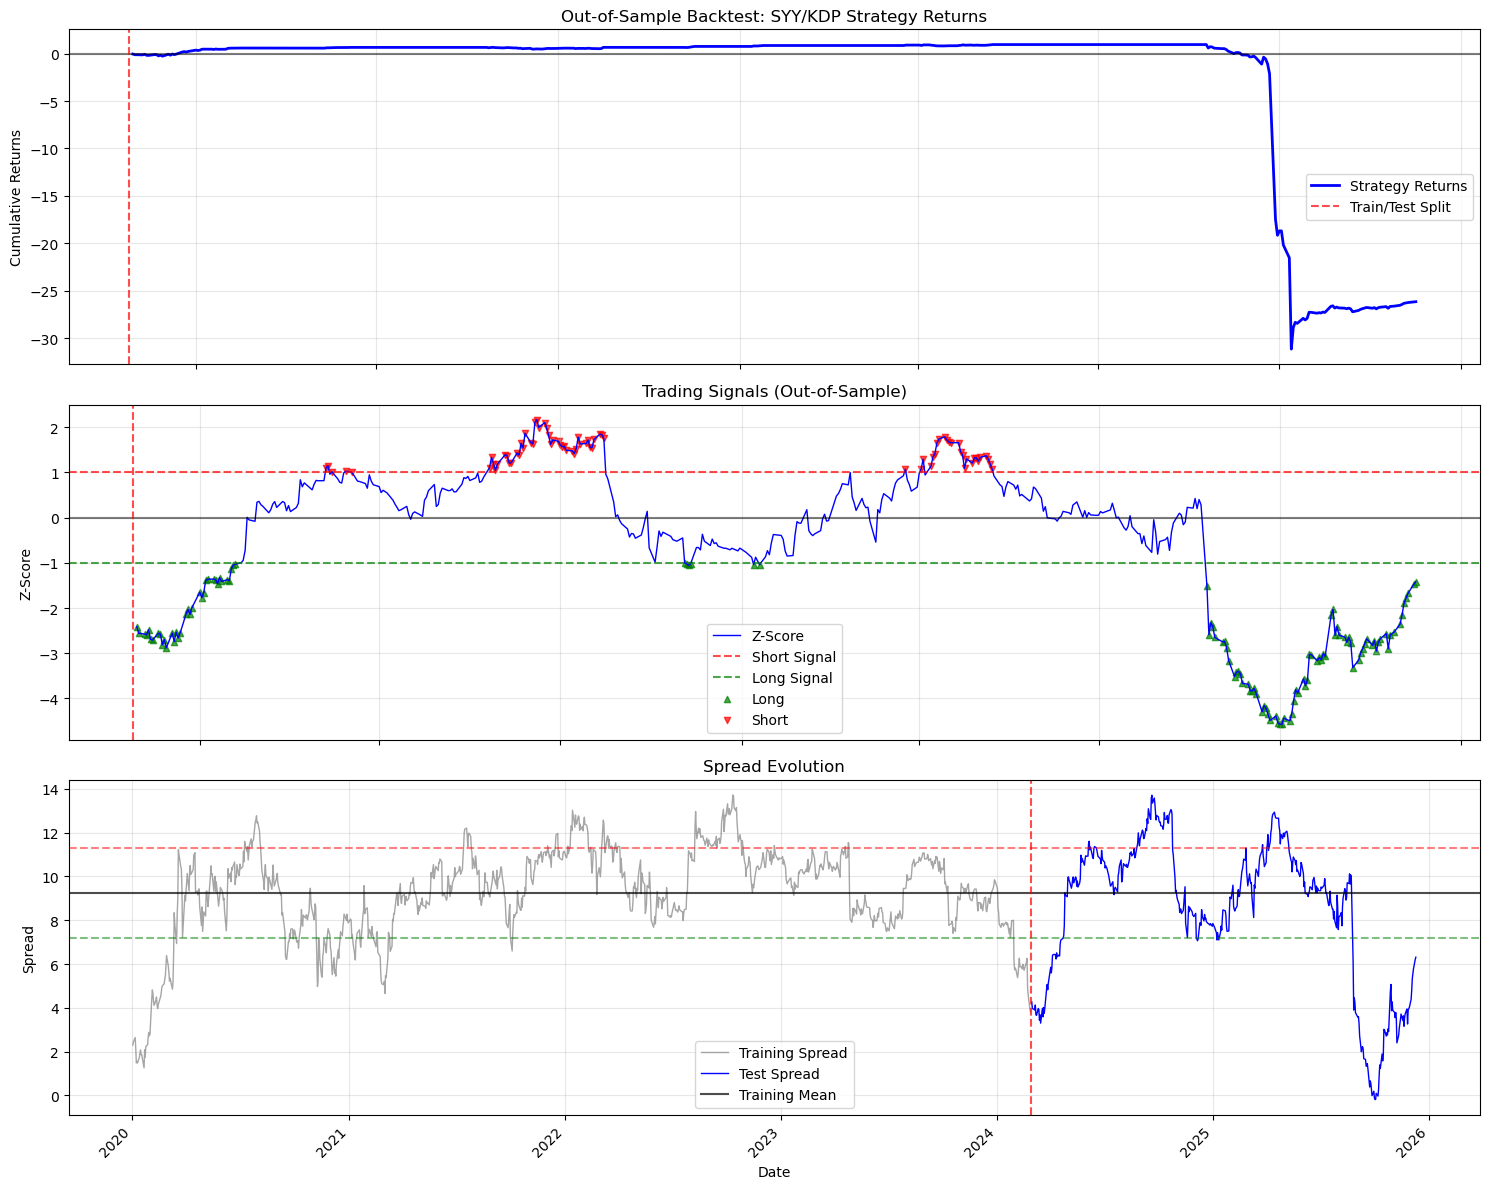


=== BACKTEST PERFORMANCE SUMMARY ===
           Metric     Value
     Total Return -2615.46%
Annualized Sharpe    -1.058
         Win Rate     55.3%
 Number of Trades       190
      Training R²     0.683
     Max Drawdown -3210.70%


In [12]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    # Ensure index is datetime for proper date formatting
    if not isinstance(signals.index, pd.DatetimeIndex):
        signals.index = pd.to_datetime(signals.index)
    
    train_spread = train_params['spread'].copy()
    if not isinstance(train_spread.index, pd.DatetimeIndex):
        train_spread.index = pd.to_datetime(train_spread.index)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    axes[0].plot(signals.index, cumulative_returns, linewidth=2, color='blue', label='Strategy Returns')
    axes[0].set_title(f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_spread.index, train_spread, 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Fix overlapping dates
    fig.autofmt_xdate(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [13]:
# Pairs Trading Analysis
# Selected Pair Analysis
# Setup regression and calculate spread

# Use the best pair from cointegration analysis
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]  # Use first consistent pair
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]  # Fallback to best training pair
    print("WARNING: No consistent pairs found. Using best training pair for demonstration.")
else:
    raise ValueError("No cointegrated pairs found. Cannot proceed with analysis.")

symbol1, symbol2 = best_pair
print(f"Analyzing pair: {symbol1}/{symbol2}")

S1 = data[symbol1]  # Independent variable
S2 = data[symbol2]  # Dependent variable

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params[symbol1]
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print(f"\n{symbol1}/{symbol2} Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

Analyzing pair: SYY/KDP

SYY/KDP Regression Results:
Hedge Ratio (beta): 0.2701
Intercept: 11.9905
R-squared: 0.4846
Spread mean: 11.9905
Spread std: 2.4856

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    KDP   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1402.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          7.98e-217
Time:                        20:14:36   Log-Likelihood:                -3477.4
No. Observations:                1493   AIC:                             6959.
Df Residuals:                    1491   BIC:                             6969.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

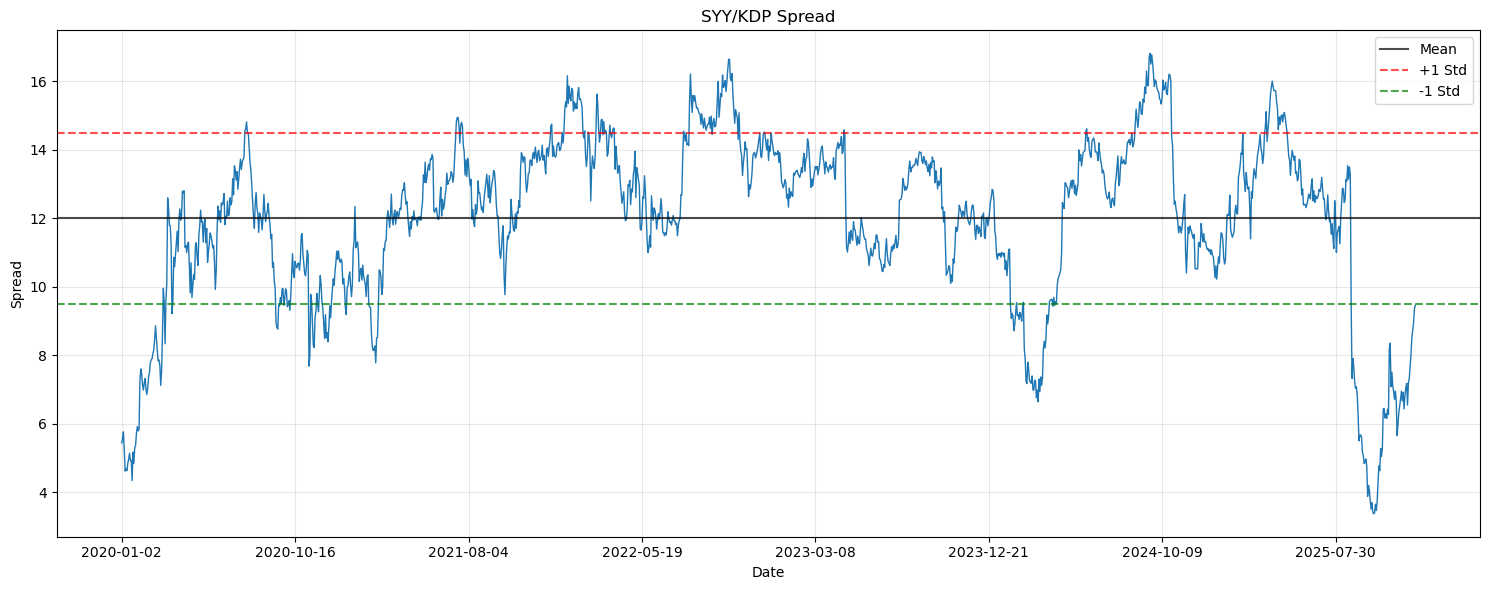

In [15]:
# Plot spread for selected pair
plt.figure(figsize=(15, 6))
spread_pair1.plot(title=f'{symbol1}/{symbol2} Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

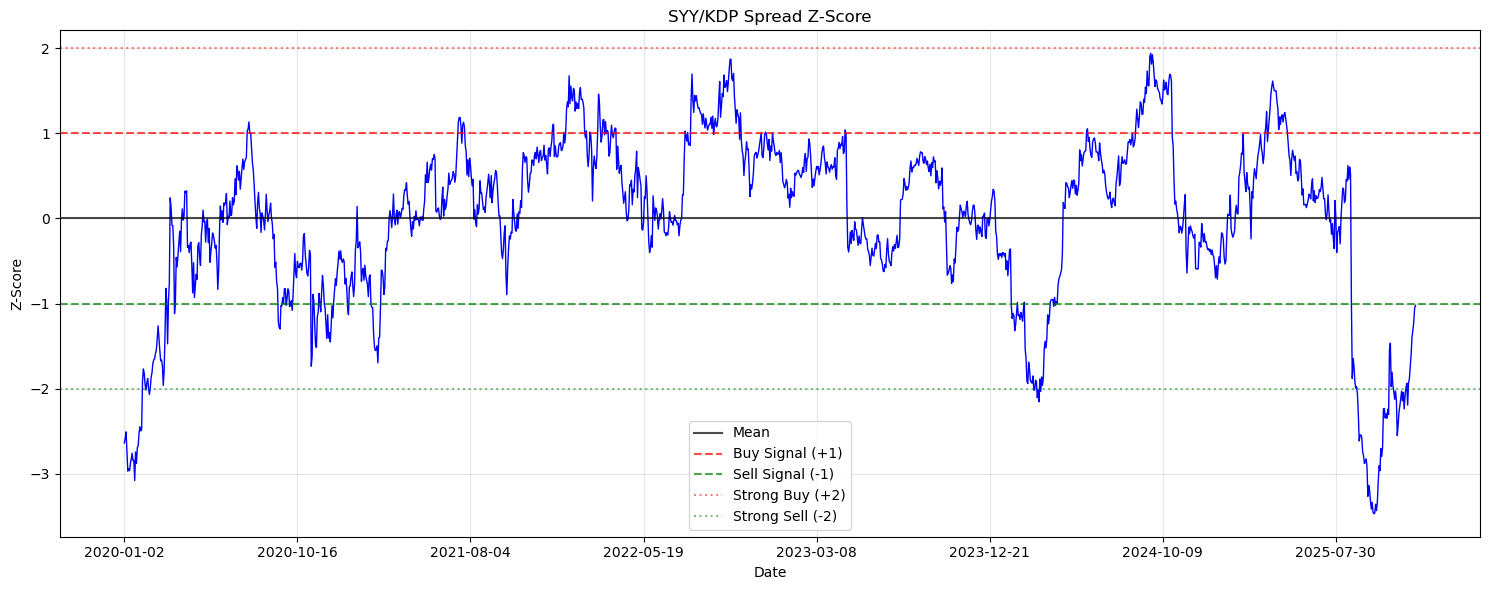

Z-score statistics for SYY/KDP:
Mean: 0.0000
Std: 1.0003
Min: -3.4670
Max: 1.9395


In [16]:
# Z-score calculation and visualization for selected pair
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title=f'{symbol1}/{symbol2} Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for {symbol1}/{symbol2}:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [17]:
# Trading Strategy for selected pair
# Create DataFrame with signal and position
trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    symbol1: S1,
    symbol2: S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print(f"{symbol1}/{symbol2} Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

SYY/KDP Trading Signals Summary:
Total trading signals: 395
Long signals: 211
Short signals: 184
Signal ratio: 26.47%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-01-03 -2.582575   1.0          0.024385
2020-01-06 -2.505747   1.0          0.034252
2020-01-07 -2.722796   1.0         -0.093562
2020-01-08 -2.967302   1.0         -0.116278
2020-01-09 -2.938062   1.0          0.015735
2020-01-10 -2.961561   1.0         -0.012449
2020-01-13 -2.877870   1.0          0.044898
2020-01-14 -2.825063   1.0          0.027113
2020-01-15 -2.757222   1.0          0.033912
2020-01-16 -2.842259   1.0         -0.041113


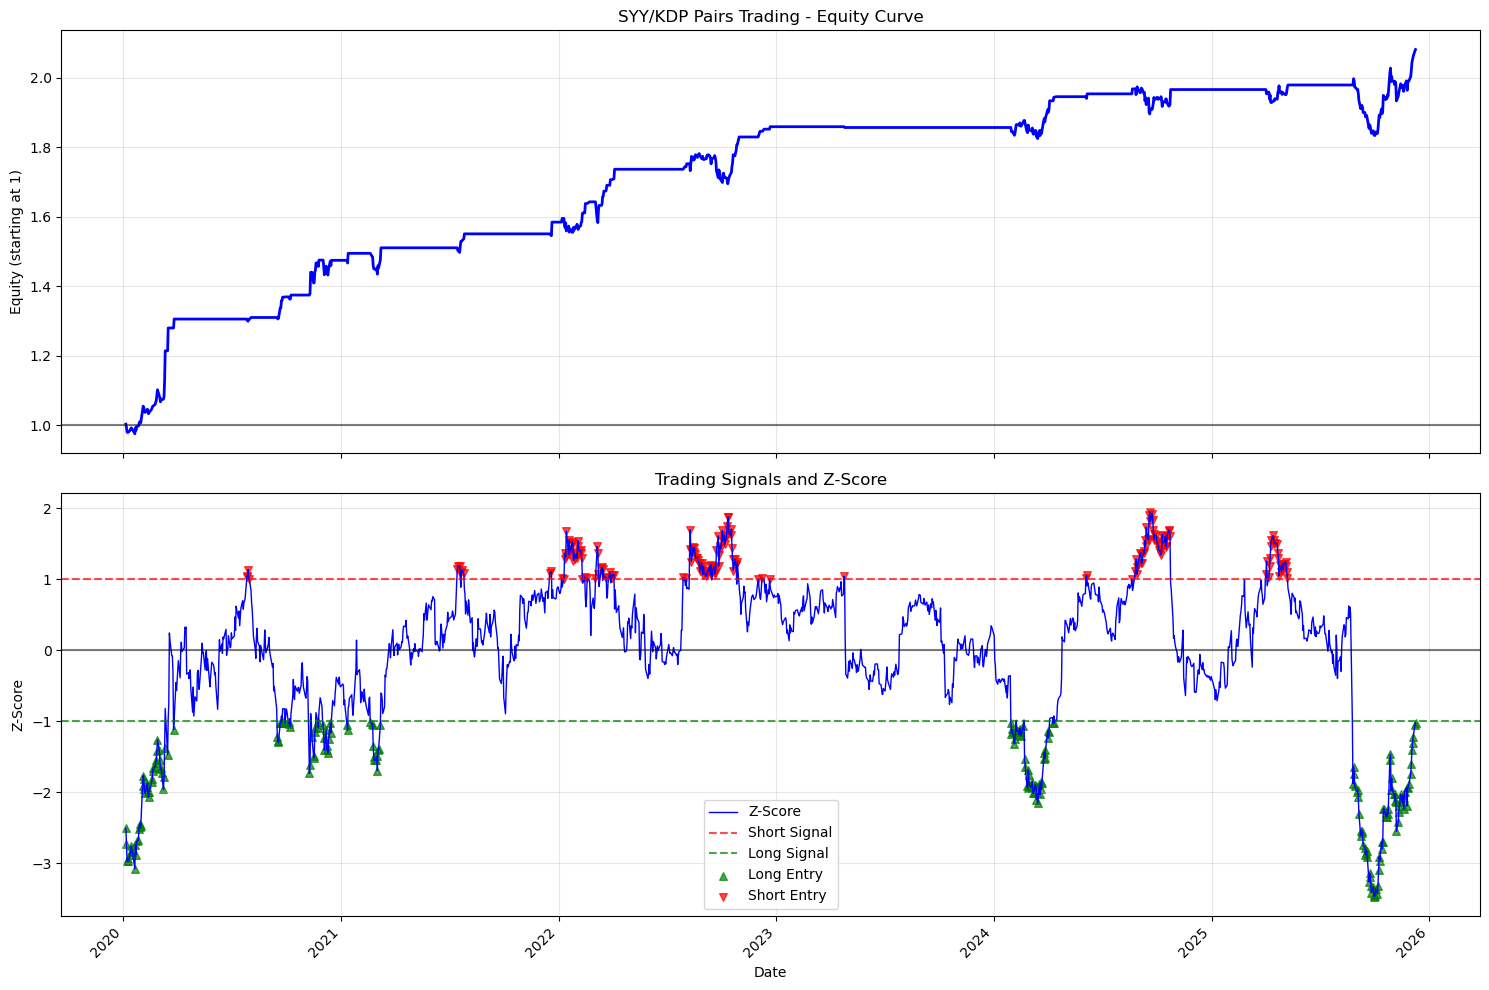


SYY/KDP Strategy Performance:
Total Return: 1.0804 (108.04%)
Annualized Sharpe Ratio: 1.5442
Maximum Drawdown: -0.0817 (-8.17%)


In [18]:
# Plot strategy performance for selected pair
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Calculate returns properly for pairs trading
# For a pairs trade: Long symbol2, Short symbol1 (when spread is expected to rise)
# Returns = weight2 * return2 - weight1 * return1
# Using equal dollar weights for simplicity

# Calculate individual stock returns
returns_S1 = S1.pct_change()
returns_S2 = S2.pct_change()

# Align with trades_pair1 index
returns_S1 = returns_S1.reindex(trades_pair1.index)
returns_S2 = returns_S2.reindex(trades_pair1.index)

# Strategy returns: when side=1 (long spread), we're long S2, short S1
# when side=-1 (short spread), we're short S2, long S1
# Use equal weights (0.5 each side)
trades_pair1['strategy_returns'] = trades_pair1.side.shift(1) * 0.5 * (returns_S2 - returns_S1)
trades_pair1 = trades_pair1.dropna()

# Ensure index is datetime for proper date formatting
if not isinstance(trades_pair1.index, pd.DatetimeIndex):
    trades_pair1.index = pd.to_datetime(trades_pair1.index)

# Plot cumulative returns using equity curve
equity_curve = (1 + trades_pair1.strategy_returns).cumprod()
axes[0].plot(trades_pair1.index, equity_curve, linewidth=2, color='blue')
axes[0].set_title(f'{symbol1}/{symbol2} Pairs Trading - Equity Curve')
axes[0].axhline(1, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Equity (starting at 1)')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Fix overlapping dates
fig.autofmt_xdate(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Performance metrics (CORRECTED)
# Total return (compounded)
total_return = equity_curve.iloc[-1] - 1

# Sharpe ratio
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)

# Max drawdown (from equity curve)
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"\n{symbol1}/{symbol2} Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

In [19]:
# ========================================================================
# add RSI(2 or 3) period of the ratio of stocks to confirm entries/exits
# ========================================================================